# Hackathon: Commuting Trends Analysis

By Jay and Richard

## Importing Libraries and Data Sets

In [1]:
#Imported relevant and necessary libraries and data cleaning tools
import pandas as pd
import numpy as np
import plotly_express as px #plotly express is a library for drawing interactive figures
import matplotlib.pyplot as plt
import seaborn as sns #seaborn is a library that uses matplotlib to make styled plots

from glob import glob as lsdir
import os
import re
import datetime as dt

In [2]:
test_data = pd.read_csv('pa_transportation.csv') #load IPUMS data on commuting patterns in PA, 2017 into Jupyter

In [3]:
#Renaming relevant columns in DataFrame to be more easily readable
names={'year' : 'Year',
       'statefip': 'State Code',
      'countyfip': 'County Code',
      'sex' : 'Sex',
      'age' : 'Age',
       'educ': 'Education Level',
      'educd' : 'Education Detail',
      'inctot' : 'Total Income',
      'tranwork' : 'Mode of Transportation',
      'carpool' : 'Do They Carpool?',
      'trantime' : 'Transportation Time',}
test_data.rename(names, inplace=True, axis=1)

## Data Cleaning

In [4]:
# fix county fips code by adding PA state code (42 to the front)
test_data['County Code'] = test_data['County Code'].apply(lambda x: x+42000 if x!=0 else 0)

In [5]:
test_data.head(20)

,Year,datanum,serial,cbserial,hhwt,State Code,County Code,gq,pernum,perwt,Sex,Age,Education Level,Education Detail,Total Income,Mode of Transportation,Do They Carpool?,Transportation Time
0,2017,1,1043132,2017000000073,88,pennsylvania,42045,households under 1970 definition,1,88,male,59,grade 12,regular high school diploma,21600,NaN,NaN,0
1,2017,1,1043133,2017000000081,102,pennsylvania,0,households under 1970 definition,1,102,male,51,5+ years of college,professional degree beyond a bachelor's degree,264000,"auto, truck, or van",drives alone,20
2,2017,1,1043133,2017000000081,102,pennsylvania,0,households under 1970 definition,2,111,female,50,4 years of college,bachelor's degree,80000,"auto, truck, or van",drives alone,25
3,2017,1,1043134,2017000000107,26,pennsylvania,0,households under 1970 definition,1,26,female,45,grade 12,regular high school diploma,0,NaN,NaN,0
4,2017,1,1043137,2017000000144,114,pennsylvania,0,households under 1970 definition,1,113,male,69,grade 12,"some college, but less than 1 year",37400,NaN,NaN,0
5,2017,1,1043138,2017000000154,314,pennsylvania,0,households under 1970 definition,1,314,female,37,grade 12,regular high school diploma,8000,NaN,NaN,0
6,2017,1,1043139,2017000000156,204,pennsylvania,42101,households under 1970 definition,1,204,male,36,1 year of college,"1 or more years of college credit, no degree",40000,"auto, truck, or van",drives alone,15
7,2017,1,1043139,2017000000156,204,pennsylvania,42101,households under 1970 definition,2,146,female,29,4 years of college,bachelor's degree,0,NaN,NaN,0
8,2017,1,1043140,2017000000228,17,pennsylvania,0,households under 1970 definition,1,17,male,26,grade 12,regular high school diploma,60000,"auto, truck, or van",drives alone,20
9,2017,1,1043140,2017000000228,17,pennsylvania,0,households under 1970 definition,2,14,female,26,2 years of college,"associate's degree, type not specified",55000,"auto, truck, or van",drives alone,60


In [6]:
test_data.drop(columns=['datanum','serial','cbserial','hhwt','gq','pernum','perwt'], inplace=True)

In [7]:
#Created 4 new DataFrames to work with from the original test_data, wanted to have different levels of inclusivity
transp_data = test_data[pd.notnull(test_data['Mode of Transportation'])] #cut DataFrame to only those with Mode of Transportation values
transp_data2 = transp_data[pd.notnull(transp_data['Do They Carpool?'])] #second DataFrame with only those with nonzero Carpool Data

transp_data3 = transp_data2.loc[transp_data2['Transportation Time'] != 0] #create separate DataFrame for only those with nonzero Transportation Time data
county_only = transp_data2.loc[transp_data2['County Code'] != 0] #create separate DataFrame for only those with nonzero County data

In [10]:
transp_data2.head()

,Year,State Code,County Code,Sex,Age,Education Level,Education Detail,Total Income,Mode of Transportation,Do They Carpool?,Transportation Time
1,2017,pennsylvania,0,male,51,5+ years of college,professional degree beyond a bachelor's degree,264000,"auto, truck, or van",drives alone,20
2,2017,pennsylvania,0,female,50,4 years of college,bachelor's degree,80000,"auto, truck, or van",drives alone,25
6,2017,pennsylvania,42101,male,36,1 year of college,"1 or more years of college credit, no degree",40000,"auto, truck, or van",drives alone,15
8,2017,pennsylvania,0,male,26,grade 12,regular high school diploma,60000,"auto, truck, or van",drives alone,20
9,2017,pennsylvania,0,female,26,2 years of college,"associate's degree, type not specified",55000,"auto, truck, or van",drives alone,60


## Carpooling by Specific Education Level

In [13]:
transp_data.groupby('Education Level').count()

,Year,State Code,County Code,Sex,Age,Education Detail,Total Income,Mode of Transportation,Do They Carpool?,Transportation Time
Education Level,,,,,,,,,,
1 year of college,7014,7014,7014,7014,7014,7014,7014,7014,5561,7014
2 years of college,5741,5741,5741,5741,5741,5741,5741,5741,5217,5741
4 years of college,12684,12684,12684,12684,12684,12684,12684,12684,10760,12684
5+ years of college,7687,7687,7687,7687,7687,7687,7687,7687,6256,7687
grade 10,436,436,436,436,436,436,436,436,365,436
grade 11,712,712,712,712,712,712,712,712,610,712
grade 12,21778,21778,21778,21778,21778,21778,21778,21778,19432,21778
"grade 5, 6, 7, or 8",532,532,532,532,532,532,532,532,348,532
grade 9,345,345,345,345,345,345,345,345,281,345


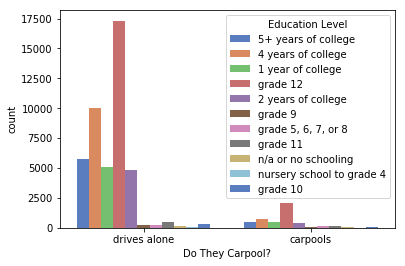

In [14]:
sns.countplot(x="Do They Carpool?", hue = "Education Level", data=transp_data2, palette='muted')

#looks like 1 or 2 years of college has the highest relative % carpoolers? but overall not too informative
#tells us our dataset has a lot of people with only a HS diploma

## Recategorize Education Buckets

In [15]:
#goes through each of the specific education outcomes and places it in one of 4 more general buckets

def educ_cat(value):
    if value=="doctoral degree" or value=="master's degree" or value=="professional degree beyond a bachelor's degree":
        x="Advanced Degree"
        return x
    elif value=="associate's degree, type not specified" or value=="bachelor's degree":
        x="Undergrad Degree"
        return x
    elif value=="some college, but less than 1 year" or value=="regular high school diploma" or value=="ged or alternative credential" or value=="1 or more years of college credit, no degree":
        x="High School Diploma"
        return x
    else:
        x="Less than HS Degree"
        return x

In [16]:
#executes the code above, applies to the entire column
transp_data.loc[:, 'Education Broad'] = transp_data.loc[:, 'Education Detail'].apply(lambda x: educ_cat(x))
transp_data2.loc[:, 'Education Broad'] = transp_data2.loc[:, 'Education Detail'].apply(lambda x: educ_cat(x))

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [37]:
#shows the number of individuals that fall under each bucket
transp_data2.groupby('Education Broad').count()

,Year,State Code,County Code,Sex,Age,Education Level,Education Detail,Total Income,Mode of Transportation,Do They Carpool?,Transportation Time
Education Broad,,,,,,,,,,,
Advanced Degree,6256,6256,6256,6256,6256,6256,6256,6256,6256,6256,6256
High School Diploma,24451,24451,24451,24451,24451,24451,24451,24451,24451,24451,24451
Less than HS Degree,2422,2422,2422,2422,2422,2422,2422,2422,2422,2422,2422
Undergrad Degree,15977,15977,15977,15977,15977,15977,15977,15977,15977,15977,15977


## Carpooling Analysis

In [40]:
#shows overall split, looks like carpoolers are about 10% of total drivers 
transp_data2.groupby('Do They Carpool?').count()

,Year,State Code,County Code,Sex,Age,Education Level,Education Detail,Total Income,Mode of Transportation,Transportation Time,Education Broad
Do They Carpool?,,,,,,,,,,,
carpools,4736,4736,4736,4736,4736,4736,4736,4736,4736,4736,4736
drives alone,44370,44370,44370,44370,44370,44370,44370,44370,44370,44370,44370


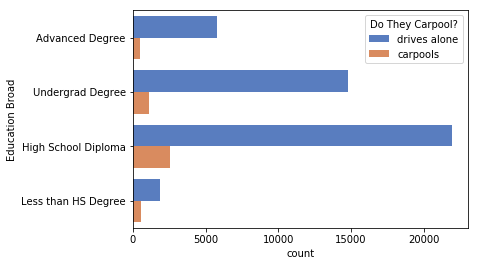

In [18]:
#plots the number of individuals that fall under each bucket
sns.countplot(y="Education Broad", hue = "Do They Carpool?", data=transp_data2, palette='muted')

In [19]:
#creates new DataFrame of percentage total splits within each education category

educ_pct = (transp_data2.groupby(['Education Broad', 'Do They Carpool?']).size() / transp_data2.groupby('Education Broad').size()).to_frame()
educ_pct.columns = ['% Category Total']
educ_pct.head(10)

% Category Total
Education Broad     Do They Carpool?                  
Advanced Degree     carpools                  0.076886
                    drives alone              0.923114
High School Diploma carpools                  0.103227
                    drives alone              0.896773
Less than HS Degree carpools                  0.241536
                    drives alone              0.758464
Undergrad Degree    carpools                  0.071728
                    drives alone              0.928272

## Analysis of Mode of Transportation vs Income

In [41]:
# count of each form of transportation to work  
transp_data.groupby("Mode of Transportation").count()

,Year,State Code,County Code,Sex,Age,Education Level,Education Detail,Total Income,Do They Carpool?,Transportation Time,Education Broad
Mode of Transportation,,,,,,,,,,,
"auto, truck, or van",49106,49106,49106,49106,49106,49106,49106,49106,49106,49106,49106
bicycle,276,276,276,276,276,276,276,276,0,276,276
bus or trolley bus,1374,1374,1374,1374,1374,1374,1374,1374,0,1374,1374
ferryboat,8,8,8,8,8,8,8,8,0,8,8
motorcycle,53,53,53,53,53,53,53,53,0,53,53
other,392,392,392,392,392,392,392,392,0,392,392
railroad,481,481,481,481,481,481,481,481,0,481,481
streetcar or trolley car,54,54,54,54,54,54,54,54,0,54,54
subway or elevated,344,344,344,344,344,344,344,344,0,344,344


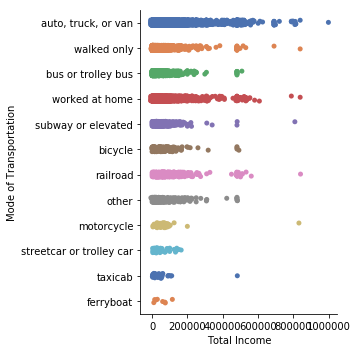

In [39]:
#Distribution of Incomes

sns.catplot(y="Mode of Transportation", x="Total Income", data=transp_data, palette="deep");

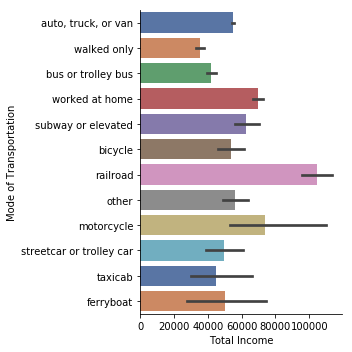

In [23]:
#Mean income under each category...rail was the highest, followed by worked at home and motorcycle
sns.catplot(y="Mode of Transportation", x="Total Income", kind="bar", data=transp_data, palette="deep");

## Analysis of Carpooling vs. Income

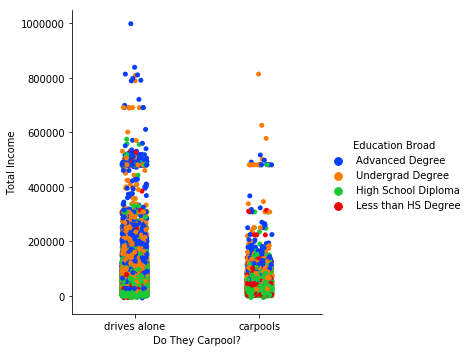

In [34]:
#scatter plot of incomes split by driving alone and carpooling; fewer high income individuals carpool
sns.catplot(x="Do They Carpool?", y="Total Income", hue="Education Broad", data=transp_data, palette = "bright");

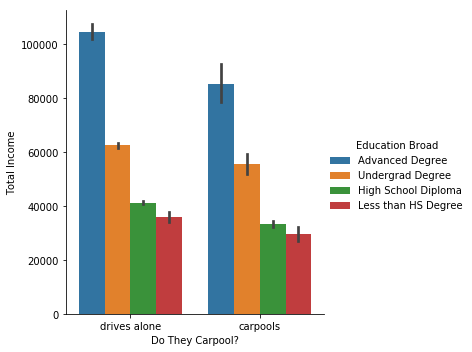

In [30]:
#Mean income under both categories, further split by education level
sns.catplot(x="Do They Carpool?", y="Total Income", hue="Education Broad", kind="bar", data=transp_data);

## Regressions of Time to Work on Total Income

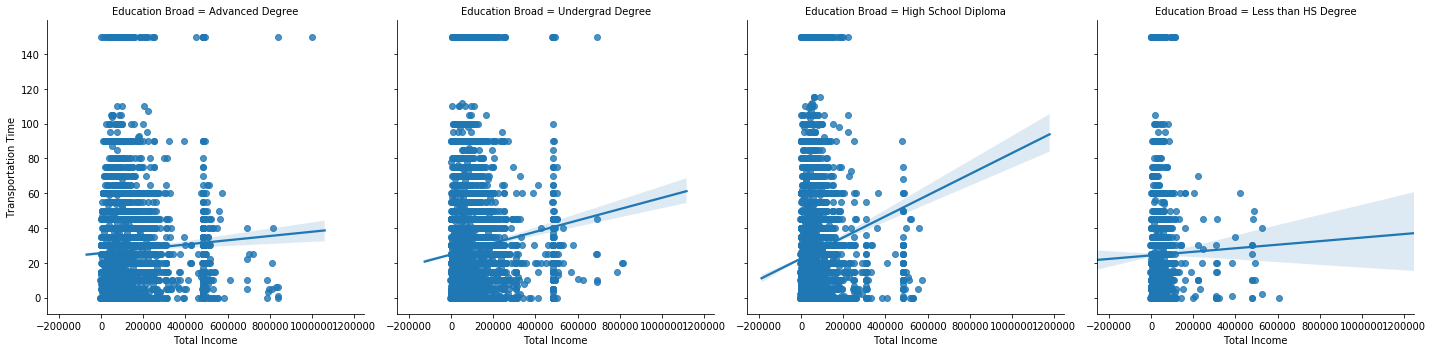

In [35]:
sns.lmplot(x="Total Income", y="Transportation Time", col="Education Broad", data=transp_data)